<br>
<left><bold><font size="5"> Customer Churn Prediction and Segmentation for Telecom</font></bold></left>
<br>
<br>


## Table of contents
* [1. Overview and Goals](#introduction)
* [2. Data Source and Use Case](#data)
* [3. ETL (Extract Transform Load)](#etl)
* [4. Analysis & Visualization](#Analysis&Visualization)
* [5. Model Training and Evaluation](#Modeling)
* [6. Customer Segmentation](#Segmentation)
* [7. Results and Discussion](#results)

## 1. Overview and Goals <a name="introduction"></a>

Customer acquisition and **retention** is a key concern for many industries, especially acute in the strongly competitive and quick growth **telecommunications** industry. Meanwhile, since the **cost** of retaining a good customer is much lower than acquiring a new one, it is very profit-effective to input valuable resource on the Retention Campaign.

Customers churn for various different reasons. Experience tells us that once the customer has made up their mind, retention becomes really hard. Therefore, managing churn in a **proactive** process is essential for the growth of the customer base and profit.

The primary goal of churn analysis is usually to create a list of contracts that are likely to be cancelled in the near future. 

The customers holding these contracts are then targeted with special incentives designed to deter cancellation.

At a more sophisticated level, the telecommunications company attempts to detect the reasons for an expected cancellation, because this information may help customize the offer.

<img style="float: left;" src='https://parcusgroup.com/public/wysiwyg/images/Telecom_Customer_Churn_Prediction_Models.jpg' width='50%'>


## 2. Data Source and Use Case <a name="data"></a>

The Data Source I've chosen here is an open source data(cell2cell) by Teradata center for customer relationship management at Duke University.

Cell2Cell dataset is preprocessed and a balanced version provided for analyzing Process. consists of 71,047 instances and 58 attributes. We can try with data set, try Machine learning algorithms and deep leaning algorithms find measures like accuracy, ROC, AUC

Telecom Industry faces fierce com-petition in satisfying its customers. The role of churn prediction system is not only restricted to accurately predict churners but also to interpret customer churn behavior.

Churn management in the telecom services industry is used to securing the customers for a company. In essence, proper customer management presumes an ability to forecast the customer decides to move to another service provider, a measurement of customer profitability, and a set of strategic and tactic retention measures to reduce the movement.

In practice, we can segment its customers by profitability and focus retention management only on those profitable segments, and score the entire customer base with propensity to churn and prioritize the retention effort based on profitability and churn propensity.

The origin link of the dataset is https://www.kaggle.com/jpacse/datasets-for-churn-telecom


In [1]:
# Import pyspark
import pyspark
from pyspark import SparkConf
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator

from pyspark.sql.types import FloatType, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Import numpy, pandas, matpoltlib, seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn import metrics

# import xgboost
import xgboost as xgb

# Import keras
import keras
from keras import Sequential, regularizers
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

sns.set_style("whitegrid")  # Set style of seaborn


In [2]:
# Create SparkSession in local environment
spark = (
    SparkSession.builder.appName("Telecom_Churn")  # create a name
    .config("spark.executor.memory", "10g")  # Maximum amount of memory allowed
    .config("spark.executor.cores", "3")  # Maximum cpu threads allowed
    .config("spark.cores.max", "3")
    .config("spark.driver.memory", "10g")
    .config("spark.sql.broadcastTimeout", "9000")
    .getOrCreate()
)
SparkConf().getAll()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/27 22:02:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/27 22:02:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[('spark.app.name', 'Telecom_Churn'),
 ('spark.sql.broadcastTimeout', '9000'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.memory', '10g'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.submitTime', '1695832350969'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.cores.max', '3')]

In [3]:
# Define a load founction
def load(path, show_num=None, printable=True):
    """
    read csv file, drop null values, print the length of the rows
    """
    data = spark.read.csv(path, header="true", inferSchema=True)
    data = data.na.drop()
    if show_num:
        data.show(show_num)

    if printable == True:
        data.printSchema()
        print("Length:", data.count())
    return data


In [4]:
# Define the path of data source and load into spark dataframe
path = "cell2celltrain.csv"
df = load(path)
df.select("MonthlyRevenue").describe().show()


root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: string (nullable = true)
 |-- MonthlyMinutes: string (nullable = true)
 |-- TotalRecurringCharge: string (nullable = true)
 |-- DirectorAssistedCalls: string (nullable = true)
 |-- OverageMinutes: string (nullable = true)
 |-- RoamingCalls: string (nullable = true)
 |-- PercChangeMinutes: string (nullable = true)
 |-- PercChangeRevenues: string (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

Length: 51023


+-------+------------------+
|summary|    MonthlyRevenue|
+-------+------------------+
|  count|             51023|
|   mean| 58.83160693573326|
| stddev|44.509141362269986|
|    min|             -2.52|
|    max|                NA|
+-------+------------------+



## 3. ETL (Extract Transform Load) <a name="etl"></a>

Before Modeling and Visualization, first of all we need follow the data engineering process, specificlly ETL process, which stands for Extract, transform, and load variables from identified data items.

Extract is the process of reading data from a database. In this stage, the data is collected, often from multiple and different types of sources.

Transform is the process of converting the extracted data from its previous form into the form it needs to be in so that it can be placed into another database. Transformation occurs by using rules or lookup tables or by combining the data with other data.

Load is the process of writing the data into the target database.

<img style="float: left;" src='https://docs.microsoft.com/en-us/azure/architecture/data-guide/images/etl.png' width='50%'>
<br>

In [5]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "NA")


In [6]:
# Check the description of Churn column
df.select("Churn").describe().show()


+-------+-----+
|summary|Churn|
+-------+-----+
|  count|49752|
|   mean| null|
| stddev| null|
|    min|   No|
|    max|  Yes|
+-------+-----+



In [7]:
# Going through all columns required to be transfer into numerical values
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string


['Churn',
 'MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser',
 'NotNewCellphoneUser',
 'OwnsMotorcycle',
 'HandsetPrice',
 'MadeCallToRetentionTeam',
 'CreditRating',
 'PrizmCode',
 'Occupation',
 'MaritalStatus']

In [8]:
# create the view of df under spark
df.createOrReplaceTempView("df")

# check the distribution of picked columns
spark.sql(
    "SELECT \
            Churn, \
            CAST (avg(MonthlyRevenue) as decimal(8,2)) as avg_MonthlyRevenue, \
            CAST (avg(MonthlyMinutes) as decimal(8,2)) as avg_MonthlyMinutes, \
            CAST (avg(CurrentEquipmentDays) as decimal(8,2)) as avg_CurrentEquipmentDays, \
            CAST (avg(TotalRecurringCharge) as decimal(8,2)) as avg_TotalRecurringCharge, \
            CAST (avg(OverageMinutes) as decimal(8,2)) as avg_OverageMinutes, \
            CAST (avg(RoamingCalls) as decimal(8,2)) as avg_RoamingCalls \
            FROM df GROUP BY Churn"
).show()


+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|Churn|avg_MonthlyRevenue|avg_MonthlyMinutes|avg_CurrentEquipmentDays|avg_TotalRecurringCharge|avg_OverageMinutes|avg_RoamingCalls|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|   No|             59.06|            541.81|                  363.64|                   47.72|             38.82|            1.16|
|  Yes|             57.87|            483.16|                  420.85|                   44.62|             42.08|            1.40|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+



In [9]:
# Check the values of string columns
df.select([column for column in df.columns if column in columns_string]).show(1)


+-----+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+-----------+--------+-------------+--------------------+------+------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+----------------+-------------------+--------------+------------+-----------------------+------------+---------+------------+-------------+
|Churn|MonthlyRevenue|MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|OverageMinutes|RoamingCalls|PercChangeMinutes|PercChangeRevenues|ServiceArea|Handsets|HandsetModels|CurrentEquipmentDays|AgeHH1|AgeHH2|ChildrenInHH|HandsetRefurbished|HandsetWebCapable|TruckOwner|RVOwner|Homeownership|BuysViaMailOrder|RespondsToMailOffers|OptOutMailings|NonUSTravel|OwnsComputer|HasCreditCard|NewCellphoneUser|NotNewCellphoneUser|OwnsMotorcycle|HandsetPrice|MadeCallToReten

In [10]:
# Based on the values of the string columns, select the list of columns for StringIndexer
columns_for_indexer = [
    "Churn",
    "ChildrenInHH",
    "HandsetRefurbished",
    "HandsetWebCapable",
    "TruckOwner",
    "RVOwner",
    "Homeownership",
    "BuysViaMailOrder",
    "RespondsToMailOffers",
    "OptOutMailings",
    "NonUSTravel",
    "OwnsComputer",
    "HasCreditCard",
    "NewCellphoneUser",
    "NotNewCellphoneUser",
    "OwnsMotorcycle",
    "MadeCallToRetentionTeam",
    "MaritalStatus",
]


In [11]:
# Loop the list and use StringIndexer encodes the string columns of labels(Yes or No) to columns of label indices(1 or 0)
for column in columns_for_indexer:
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    df = indexer.fit(df).transform(df)


In [12]:
# Drop the original string columns of labels
df = df.select([column for column in df.columns if column not in columns_for_indexer])


In [13]:
# Check the Churn column again to confirm the result
df.select("ChurnIndex").describe().show()


+-------+-------------------+
|summary|         ChurnIndex|
+-------+-------------------+
|  count|              49752|
|   mean|0.28632014793375143|
| stddev|0.45204538278095574|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [14]:
# Replace unknown values to 0 for Price Column
df = df.replace(to_replace={"Unknown": "0"}, subset=["HandsetPrice"])


In [15]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "Unknown")


In [16]:
# Another Iteration for feature engineering
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string


['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'HandsetPrice',
 'CreditRating',
 'PrizmCode',
 'Occupation']

In [17]:
# Mapping string values into integer based on its values
mapping_PrizmCode = {"Other": "0", "Suburban": "1", "Town": "2", "Rural": "3"}
df = df.replace(to_replace=mapping_PrizmCode, subset=["PrizmCode"])


In [18]:
# Prepare the list of columns to be transformed into float
columns_to_float = [
    "MonthlyRevenue",
    "MonthlyMinutes",
    "TotalRecurringCharge",
    "DirectorAssistedCalls",
    "OverageMinutes",
    "RoamingCalls",
    "PercChangeMinutes",
    "PercChangeRevenues",
]


In [19]:
# Transform ServiceArea and CreditRating columns only to keep the int value
df = df.withColumn("ServiceArea", df["ServiceArea"].substr(-3, 3))
df = df.withColumn("CreditRating", df["CreditRating"].substr(1, 1))


In [20]:
# Transform the type of columns to float
for column in columns_to_float:
    df = df.withColumn(column, df[column].cast("float"))


In [21]:
# Create a Pandas DataFrame for data visualization
df_pd = df.toPandas()


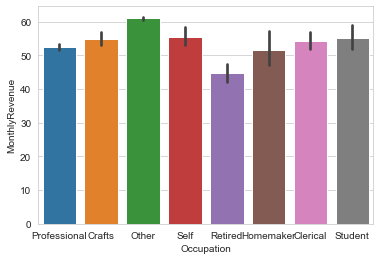

In [22]:
# Before transform the type of Occupation column, let's check it's distribution first
graph = df_pd[["Occupation", "MonthlyRevenue"]]
ax = sns.barplot(x="Occupation", y="MonthlyRevenue", data=graph)


In [23]:
# Transform string values to numbers using mapping
temp = (
    df_pd.loc[:, ["Occupation", "MonthlyRevenue"]]
    .groupby("Occupation")
    .mean()
    .sort_values(["MonthlyRevenue"], ascending=[0])
)

mapping_Occupation = dict([temp.index[i], str(i)] for i in range(len(temp)))
print(mapping_Occupation)

df = df.replace(to_replace=mapping_Occupation, subset=["Occupation"])


{'Other': '0', 'Self': '1', 'Student': '2', 'Crafts': '3', 'Clerical': '4', 'Professional': '5', 'Homemaker': '6', 'Retired': '7'}


In [24]:
df.describe()


DataFrame[summary: string, CustomerID: string, MonthlyRevenue: string, MonthlyMinutes: string, TotalRecurringCharge: string, DirectorAssistedCalls: string, OverageMinutes: string, RoamingCalls: string, PercChangeMinutes: string, PercChangeRevenues: string, DroppedCalls: string, BlockedCalls: string, UnansweredCalls: string, CustomerCareCalls: string, ThreewayCalls: string, ReceivedCalls: string, OutboundCalls: string, InboundCalls: string, PeakCallsInOut: string, OffPeakCallsInOut: string, DroppedBlockedCalls: string, CallForwardingCalls: string, CallWaitingCalls: string, MonthsInService: string, UniqueSubs: string, ActiveSubs: string, ServiceArea: string, Handsets: string, HandsetModels: string, CurrentEquipmentDays: string, AgeHH1: string, AgeHH2: string, RetentionCalls: string, RetentionOffersAccepted: string, ReferralsMadeBySubscriber: string, IncomeGroup: string, AdjustmentsToCreditRating: string, HandsetPrice: string, CreditRating: string, PrizmCode: string, Occupation: string, C

In [25]:
# Prepare the list of columns to be transformed into integer
columns_to_int = [
    "Handsets",
    "HandsetModels",
    "CurrentEquipmentDays",
    "AgeHH1",
    "AgeHH2",
    "HandsetPrice",
    "ServiceArea",
    "CreditRating",
    "PrizmCode",
    "Occupation",
    "ChurnIndex",
    "ChildrenInHHIndex",
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "TruckOwnerIndex",
    "RVOwnerIndex",
    "HomeownershipIndex",
    "BuysViaMailOrderIndex",
    "RespondsToMailOffersIndex",
    "OptOutMailingsIndex",
    "NonUSTravelIndex",
    "OwnsComputerIndex",
    "HasCreditCardIndex",
    "NewCellphoneUserIndex",
    "NotNewCellphoneUserIndex",
    "OwnsMotorcycleIndex",
    "MadeCallToRetentionTeamIndex",
    "MaritalStatusIndex",
]


In [26]:
# Transform the type of columns to integer
for column in columns_to_int:
    df = df.withColumn(column, df[column].cast("int"))


## 4. Analysis & Visualization <a name="Analysis&Visualization"></a>

Before go to next step, I'd like to do some Analysis & Visualization of the features we just cleaned. So we can have better understanding on the business aspect.

Based on the industry experience, usually there're five dimensions and listed below are the significant variables.
-	Customer demography: Age, Tenure, Gender, Location, Zip code, etc.
-	Bill and payment: Monthly fee, Billing amount, Count of overdue payment, payment method, Billing type, etc.
-	Network/TV/Phone usage records: Network use frequency, network flow, usage time and period, internet average speed, In-net call duration, Call type, etc.
-	Customer care/service: Service call number, service type, service duration, account change count
-	Competitors information: Offer detail under similar plan, etc

As we can see based on our original database, we're lack of several features such as competitors information. In the real business projects I experienced that is extremely important, however since we're only showing technical process here, I'll just leave it.

In [27]:
# Go through the dataset check the distribution of each feature
for i in range(len(df.columns) // 6 + 1):
    df.describe(df.columns[6 * i : 6 * (i + 1)]).show()


+-------+------------------+------------------+-----------------+--------------------+---------------------+-----------------+
|summary|        CustomerID|    MonthlyRevenue|   MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|   OverageMinutes|
+-------+------------------+------------------+-----------------+--------------------+---------------------+-----------------+
|  count|             49752|             49752|            49752|               49752|                49752|            49752|
|   mean|  3200957.68290722| 58.71737385609968|525.0214664737096|   46.83496140858659|   0.8918407307885328|39.75404003859141|
| stddev|116469.39654595837|44.317243781725885|528.5101549841828|   23.75949230234843|    2.224725327478727|96.09160595755405|
|    min|           3000002|             -6.17|              0.0|                -6.0|                  0.0|              0.0|
|    max|           3399974|           1223.38|           7359.0|               400.0|               159.39|   

+-------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|      RoamingCalls|  PercChangeMinutes| PercChangeRevenues|     DroppedCalls|      BlockedCalls|   UnansweredCalls|
+-------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|             49752|              49752|              49752|            49752|             49752|             49752|
|   mean|1.2263265816986915|-11.656174626145683|-1.1759366413094985|6.010556359543353|4.0778139572278995|28.290957147451355|
| stddev| 9.848360375386692| 255.85819278703568|   39.3921242390768|9.036653174542684|  10.8364682651841|38.860428731292835|
|    min|               0.0|            -3875.0|            -1107.7|              0.0|               0.0|               0.0|
|    max|            1112.4|             5192.0|             2483.5|            221.7|             324.7|             848.7|


+-------+------------------+-------------------+------------------+------------------+------------------+-----------------+
|summary| CustomerCareCalls|      ThreewayCalls|     ReceivedCalls|     OutboundCalls|      InboundCalls|   PeakCallsInOut|
+-------+------------------+-------------------+------------------+------------------+------------------+-----------------+
|  count|             49752|              49752|             49752|             49752|             49752|            49752|
|   mean|1.8740311947258304|0.29842217398296084|114.70921369995202|25.350315565203363| 8.163665782280168|90.45041405370621|
| stddev| 5.111285263665452| 1.1710835484571285|166.10718501787744| 35.02414580876004|16.586856287560444|104.6009363809446|
|    min|               0.0|                0.0|               0.0|               0.0|               0.0|              0.0|
|    max|             327.3|               66.0|            2692.4|             644.3|             519.3|           2090.7|
+-------

+-------+-----------------+-------------------+--------------------+-----------------+------------------+------------------+
|summary|OffPeakCallsInOut|DroppedBlockedCalls| CallForwardingCalls| CallWaitingCalls|   MonthsInService|        UniqueSubs|
+-------+-----------------+-------------------+--------------------+-----------------+------------------+------------------+
|  count|            49752|              49752|               49752|            49752|             49752|             49752|
|   mean|67.71137843704788| 10.149177922495562|0.011772391059655898|1.837228654124436|18.730804791767167| 1.529003859141341|
| stddev|92.73606296743107| 15.456030718710382|   0.582402159803974|5.590514635892602| 9.739417720482239|1.2258410690343606|
|    min|              0.0|                0.0|                 0.0|              0.0|                 6|                 1|
|    max|           1474.7|              339.0|                81.3|            212.7|                61|               196|


+-------+------------------+-----------------+------------------+------------------+--------------------+------------------+
|summary|        ActiveSubs|      ServiceArea|          Handsets|     HandsetModels|CurrentEquipmentDays|            AgeHH1|
+-------+------------------+-----------------+------------------+------------------+--------------------+------------------+
|  count|             49752|            49752|             49752|             49752|               49752|             49752|
|   mean|1.3508602669239427|581.7103634024763|1.8050932625824088|1.5587112075896445|   380.0208433831806|31.338257758482072|
| stddev|0.6678388932763878|245.6005479634547|1.3308343115391086|0.9062561260922284|  252.29007230769398|22.091592990054497|
|    min|                 0|              201|                 1|                 1|                  -5|                 0|
|    max|                53|              978|                24|                15|                1812|                99|


+-------+------------------+-------------------+-----------------------+-------------------------+-----------------+-------------------------+
|summary|            AgeHH2|     RetentionCalls|RetentionOffersAccepted|ReferralsMadeBySubscriber|      IncomeGroup|AdjustmentsToCreditRating|
+-------+------------------+-------------------+-----------------------+-------------------------+-----------------+-------------------------+
|  count|             49752|              49752|                  49752|                    49752|            49752|                    49752|
|   mean| 21.14759205660074|0.03549606045988101|   0.018330921369995177|      0.05147531757517286|4.402677279305355|     0.053686283968483677|
| stddev|23.926589044698183|0.20196388392084083|     0.1428540241288854|       0.2664903363890623|3.110497991083677|       0.3826765692678388|
|    min|                 0|                  0|                      0|                        0|                0|                        0|

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|      HandsetPrice|      CreditRating|         PrizmCode|        Occupation|         ChurnIndex| ChildrenInHHIndex|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|             49752|             49752|             49752|             49752|              49752|             49752|
|   mean| 35.52078308409712|2.8645280591735007| 0.767888728091333| 1.195771024280431|0.28632014793375143|0.2466031516320952|
| stddev|56.847654093816004|1.5686274673069813|0.8761360053400633|2.0967301364866002|0.45204538278095574|0.4310380164617272|
|    min|                 0|                 1|                 0|                 0|                  0|                 0|
|    max|               500|                 7|                 3|                 7|                  1|                 1|


+-------+-----------------------+----------------------+------------------+-------------------+-------------------+---------------------+
|summary|HandsetRefurbishedIndex|HandsetWebCapableIndex|   TruckOwnerIndex|       RVOwnerIndex| HomeownershipIndex|BuysViaMailOrderIndex|
+-------+-----------------------+----------------------+------------------+-------------------+-------------------+---------------------+
|  count|                  49752|                 49752|             49752|              49752|              49752|                49752|
|   mean|    0.13868789194404246|   0.09742321916706866|0.1903843061585464|0.08307203730503296|0.32213780350538673|  0.36822640295867504|
| stddev|      0.345624017684669|   0.29653617481642747|0.3926082275226941|0.27599384951319533|0.46730014788881047|   0.4823280990401213|
|    min|                      0|                     0|                 0|                  0|                  0|                    0|
|    max|                      1| 

+-------+-------------------------+-------------------+-------------------+-------------------+------------------+---------------------+
|summary|RespondsToMailOffersIndex|OptOutMailingsIndex|   NonUSTravelIndex|  OwnsComputerIndex|HasCreditCardIndex|NewCellphoneUserIndex|
+-------+-------------------------+-------------------+-------------------+-------------------+------------------+---------------------+
|  count|                    49752|              49752|              49752|              49752|             49752|                49752|
|   mean|      0.38360266923942754| 0.0149943720855443|0.05740472744814279|0.18861553304389772|0.3117663611513105|  0.19317816369191187|
| stddev|       0.4862678419281865|0.12153122134057211|   0.23261666389043| 0.3912068376853646|0.4632196131919147|   0.3947955085523832|
|    min|                        0|                  0|                  0|                  0|                 0|                    0|
|    max|                        1|      

+-------+------------------------+--------------------+----------------------------+------------------+
|summary|NotNewCellphoneUserIndex| OwnsMotorcycleIndex|MadeCallToRetentionTeamIndex|MaritalStatusIndex|
+-------+------------------------+--------------------+----------------------------+------------------+
|  count|                   49752|               49752|                       49752|             49752|
|   mean|     0.13818539958192635|0.013547194082649944|        0.032581604759607655|0.8783566489789355|
| stddev|      0.3450979406617156| 0.11560249230086767|          0.1775406357622975|0.7831029786450292|
|    min|                       0|                   0|                           0|                 0|
|    max|                       1|                   1|                           1|                 2|
+-------+------------------------+--------------------+----------------------------+------------------+



In [28]:
# Create a new Pandas DataFrame for data visualization
df_pd = df.toPandas()


In [29]:
# Define Catplot function and Barplot function
def cat_plot(feature, cut=12):
    temp = df_pd.loc[:, [feature, "ChurnIndex"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="ChurnIndex",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "ChurnIndex"]]
    else:
        temp = df_pd.loc[:, [feature, "ChurnIndex"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="ChurnIndex", data=temp)
    else:
        ax = sns.barplot(x=feature, y="ChurnIndex", data=temp)

    if logscale:
        ax.set_yscale("log")


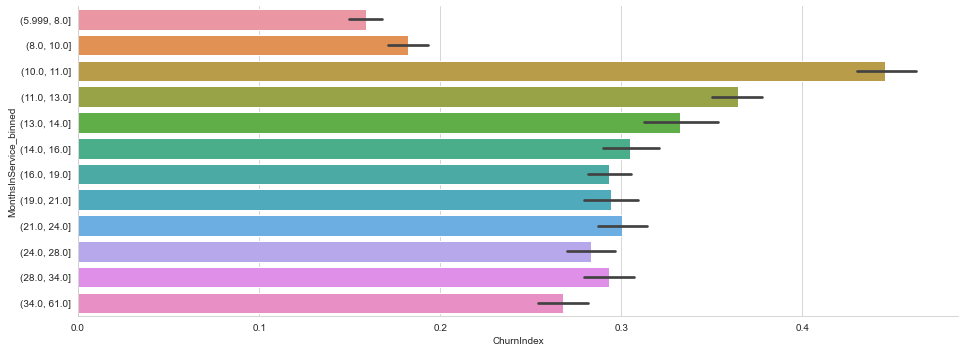

In [30]:
# Use defined Catplot function plot the distribution of MonthsInService
cat_plot("MonthsInService", cut=12)


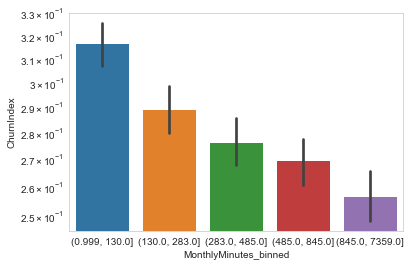

In [31]:
# Use defined Barplot function plot the distribution of MonthlyMinutes
bar_plot("MonthlyMinutes", cut=5, logscale=True, drop_zero=True)


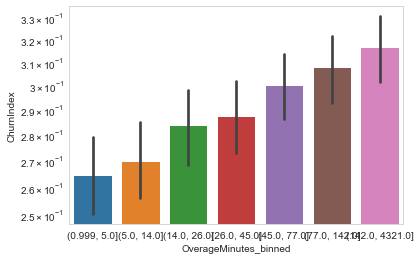

In [32]:
# Use defined Barplot function plot the distribution of OverageMinutes
bar_plot("OverageMinutes", cut=7, logscale=True, drop_zero=True)


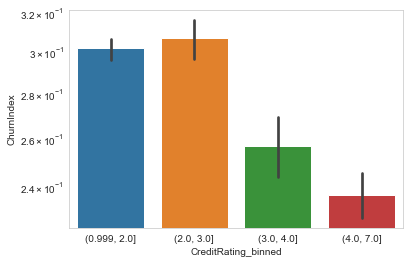

In [33]:
# Use defined Barplot function plot the distribution of CreditRating
bar_plot("CreditRating", cut=5, logscale=True)


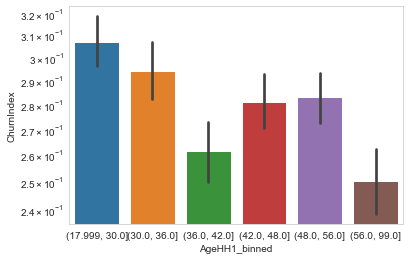

In [34]:
# Use defined Barplot function plot the distribution of AgeHH1
bar_plot("AgeHH1", cut=6, logscale=True, drop_zero=True)


<AxesSubplot:xlabel='MadeCallToRetentionTeam', ylabel='ChurnIndex'>

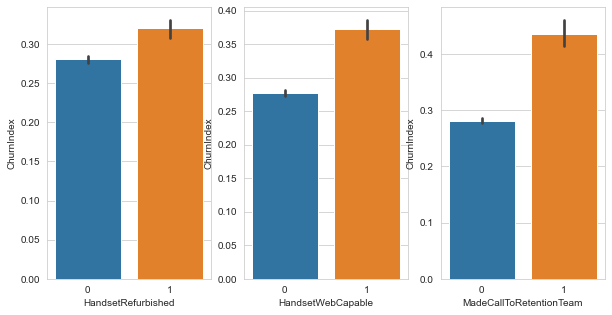

In [35]:
# Subplots the distribution of HandsetRefurbished, HandsetWebCapable and MadeCallToRetentionTeam into one graph
feature = [
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "MadeCallToRetentionTeamIndex",
    "ChurnIndex",
]
temp = df_pd.loc[:, feature]
temp.columns = [
    "HandsetRefurbished",
    "HandsetWebCapable",
    "MadeCallToRetentionTeam",
    "ChurnIndex",
]

fig, axs = plt.subplots(figsize=(10, 5), ncols=3)
sns.barplot(x="HandsetRefurbished", y="ChurnIndex", data=temp, ax=axs[0])
sns.barplot(x="HandsetWebCapable", y="ChurnIndex", data=temp, ax=axs[1])
sns.barplot(x="MadeCallToRetentionTeam", y="ChurnIndex", data=temp, ax=axs[2])


## 5. Prediction Model Training and Evaluation <a name="Modeling"></a>

The first step of this module is data preprocessing. We'll start from VectorAssembler, which is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like Random Forest and Gradient-Boosted Trees. Next, since we're going to use K-Means and Neural Network for the modeling, we're going to use StandardScaler transforms the dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean. Last, we'll use down-samplings method to deal with our unbalance dataset.

Next Step is modeling, in this project we'll use Random Forest Classifier and GBTs Classifier to predict customer Churn; Use XGBoost Regressor and Neural Network to predict Revenue Loss.

In the last part of each modeling iteration is evaluate the performance of each prediction model, in order to do so, we will split the dataset in 2 parts: training set (80% of the entries in the dataset) and test set (20% of the entries in the dataset). We train the model on the training set and then we test the model on the test set. I decided to use the ROC curve(A receiver operating characteristic curve) to test the model performance for classification problem which is to predict customer Churn in our case; And use mean absolute error for regression program which is predicted revenue loss in our case, then I'll plot a chart of how many of total revenue loss can be covered with our predicted highest risk group.


### 5.1 Data Preprocessing

In [36]:
# Create column list for VectorAssembler
inputcols = [
    column for column in df.columns if column not in ["CustomerID", "ChurnIndex"]
]


In [37]:
# Use vectorAssembler transform the given list of columns into a single vector column.
vectorAssembler = VectorAssembler(inputCols=inputcols, outputCol="features")
features_vectorized = vectorAssembler.transform(df)
features_vectorized = features_vectorized.withColumnRenamed("ChurnIndex", "label")


In [38]:
# StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(features_vectorized)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(features_vectorized)
scaledData.show()


+----------+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+--------------+-----------------------+-------------------------+-----------+-------------------------+------------+------------+---------+----------+-----+-----------------+-----------------------+----------------------+---------------+------------+------------------+---------------------+-------------------------+-------------------+----------------+-----------------+------------------+---------------------+------------------------+-------------------+----------------------------+------------------+--------------------+----------

In [42]:
# Check the distribution of label
scaledData.select("label").groupBy("label").count().collect()


[Row(label=1, count=14245), Row(label=0, count=35507)]

Since the data set is highly skewed – we have much more Negative training samples than Positive training samples – we will need to try out some strategies that counter the unbalance.

Here I'm going to use one of the simplest method called down-samplings, which means we just randomly filter out some of the majority cases.

In [43]:
# Down-sampling
scaledData_ds, _ = scaledData.filter(scaledData["label"] == 0.0).randomSplit([0.4, 0.6])
scaledData_ds = scaledData.filter(scaledData["label"] == 1.0).union(scaledData_ds)
scaledData_ds.select("label").groupBy("label").count().collect()


[Row(label=1, count=14245), Row(label=0, count=14274)]

In [44]:
# Split dataset into train and test set
train, test = scaledData_ds.randomSplit([0.8, 0.2])


In [45]:
# Define plot roc curve function
def plot_roc_curve(model, train, test):
    predictions = model.transform(test)
    predictions_train = model.transform(train)

    results = predictions.select(["probability", "label"])
    results_train = predictions_train.select(["probability", "label"])

    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

    results_collect_train = results_train.collect()
    results_list_train = [
        (float(i[0][0]), 1.0 - float(i[1])) for i in results_collect_train
    ]

    fpr = dict()
    fpr_train = dict()
    tpr = dict()
    tpr_train = dict()
    roc_auc = dict()
    roc_auc_train = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    y_train = [i[1] for i in results_list_train]
    y_score_train = [i[0] for i in results_list_train]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve on testing set (area = %0.2f)" % roc_auc)
    plt.plot(
        fpr_train,
        tpr_train,
        label="ROC curve on training set (area = %0.2f)" % roc_auc_train,
    )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


### 5.2 Random Forest Classifier

In [46]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
rf = RandomForestClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction", maxBins=16
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [8, 10, 12])
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 10])
    .addGrid(rf.numTrees, [50, 100])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)


23/09/26 20:56:58 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB


23/09/26 20:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB


23/09/26 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 20:57:05 WARN DAGScheduler: Broadcasting large task binary with size 1864.0 KiB


23/09/26 20:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1114.6 KiB


23/09/26 20:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1545.6 KiB


23/09/26 20:57:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 20:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 20:57:26 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/26 20:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB


23/09/26 20:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1493.6 KiB


23/09/26 20:57:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 20:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1732.2 KiB
23/09/26 20:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1115.2 KiB


23/09/26 20:57:41 WARN DAGScheduler: Broadcasting large task binary with size 1549.7 KiB


23/09/26 20:57:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 20:57:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/09/26 20:57:50 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/09/26 20:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1109.1 KiB


23/09/26 20:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1489.6 KiB


23/09/26 20:57:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 20:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1655.1 KiB


23/09/26 20:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1116.8 KiB


23/09/26 20:58:08 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB


23/09/26 20:58:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 20:58:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 20:58:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/09/26 20:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1106.2 KiB


23/09/26 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 1470.6 KiB


23/09/26 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/26 20:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1557.7 KiB


23/09/26 20:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB


23/09/26 20:58:30 WARN DAGScheduler: Broadcasting large task binary with size 1543.2 KiB


23/09/26 20:58:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/26 20:58:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


23/09/26 20:58:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/09/26 20:58:42 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
23/09/26 20:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB


23/09/26 20:58:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 20:58:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/09/26 20:58:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/09/26 20:58:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/09/26 20:58:55 WARN DAGScheduler: Broadcasting large task binary with size 1114.6 KiB


23/09/26 20:58:56 WARN DAGScheduler: Broadcasting large task binary with size 1545.6 KiB


23/09/26 20:58:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 20:59:00 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 20:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/26 20:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB


23/09/26 20:59:08 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


23/09/26 20:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1435.2 KiB


23/09/26 20:59:15 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


23/09/26 20:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
23/09/26 20:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1493.6 KiB


23/09/26 20:59:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 20:59:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/09/26 20:59:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/09/26 20:59:30 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/09/26 20:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1115.2 KiB


23/09/26 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1549.7 KiB


23/09/26 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/09/26 20:59:42 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/26 20:59:45 WARN DAGScheduler: Broadcasting large task binary with size 1080.5 KiB


23/09/26 20:59:47 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


23/09/26 20:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1527.7 KiB


23/09/26 20:59:53 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/09/26 20:59:58 WARN DAGScheduler: Broadcasting large task binary with size 1109.1 KiB
23/09/26 20:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1489.6 KiB


23/09/26 21:00:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 21:00:02 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/26 21:00:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/09/26 21:00:07 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/09/26 21:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1116.8 KiB


23/09/26 21:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB


23/09/26 21:00:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 21:00:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 21:00:19 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/09/26 21:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB


23/09/26 21:00:24 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/09/26 21:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1500.4 KiB


23/09/26 21:00:30 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


23/09/26 21:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1106.2 KiB
23/09/26 21:00:35 WARN DAGScheduler: Broadcasting large task binary with size 1470.6 KiB


23/09/26 21:00:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/26 21:00:37 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/09/26 21:00:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/09/26 21:00:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/09/26 21:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB


23/09/26 21:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1543.2 KiB


23/09/26 21:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/26 21:00:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


23/09/26 21:00:54 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/09/26 21:00:57 WARN DAGScheduler: Broadcasting large task binary with size 1020.9 KiB


23/09/26 21:00:58 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/09/26 21:01:02 WARN DAGScheduler: Broadcasting large task binary with size 1371.5 KiB


23/09/26 21:01:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/09/26 21:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
23/09/26 21:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB


23/09/26 21:01:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 21:01:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/09/26 21:01:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/09/26 21:01:17 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/09/26 21:01:21 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/09/26 21:01:23 WARN DAGScheduler: Broadcasting large task binary with size 1121.2 KiB


23/09/26 21:01:26 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


23/09/26 21:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1114.6 KiB


23/09/26 21:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1545.6 KiB


23/09/26 21:01:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 21:01:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 21:01:38 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/26 21:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB


23/09/26 21:01:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


23/09/26 21:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1435.2 KiB


23/09/26 21:01:48 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


23/09/26 21:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1883.6 KiB


23/09/26 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


23/09/26 21:02:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/26 21:02:10 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


23/09/26 21:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
23/09/26 21:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1493.6 KiB


23/09/26 21:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 21:02:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/09/26 21:02:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/09/26 21:02:24 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


23/09/26 21:02:26 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB


23/09/26 21:02:27 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


23/09/26 21:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1231.0 KiB


23/09/26 21:02:33 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/09/26 21:02:37 WARN DAGScheduler: Broadcasting large task binary with size 1115.2 KiB


23/09/26 21:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1549.7 KiB


23/09/26 21:02:40 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 21:02:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/09/26 21:02:46 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/09/26 21:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1080.5 KiB


23/09/26 21:02:51 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


23/09/26 21:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1527.7 KiB


23/09/26 21:02:58 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


23/09/26 21:03:02 WARN DAGScheduler: Broadcasting large task binary with size 2016.9 KiB


23/09/26 21:03:06 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


23/09/26 21:03:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/09/26 21:03:17 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


23/09/26 21:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1109.1 KiB


23/09/26 21:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1489.6 KiB


23/09/26 21:03:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/09/26 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/26 21:03:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/09/26 21:03:31 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/09/26 21:03:34 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/09/26 21:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB


23/09/26 21:03:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/09/26 21:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1116.8 KiB


23/09/26 21:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB


23/09/26 21:03:48 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 21:03:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 21:03:54 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/09/26 21:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB


23/09/26 21:03:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/09/26 21:04:06 WARN DAGScheduler: Broadcasting large task binary with size 1500.4 KiB


23/09/26 21:04:11 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


23/09/26 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1955.4 KiB


23/09/26 21:04:23 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


23/09/26 21:04:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/26 21:04:34 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


23/09/26 21:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1106.2 KiB


23/09/26 21:04:41 WARN DAGScheduler: Broadcasting large task binary with size 1470.6 KiB


23/09/26 21:04:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/26 21:04:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/09/26 21:04:46 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/09/26 21:04:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/09/26 21:04:52 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/09/26 21:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB


23/09/26 21:04:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/09/26 21:05:01 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB


23/09/26 21:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1543.2 KiB


23/09/26 21:05:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/26 21:05:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


23/09/26 21:05:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/09/26 21:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1020.9 KiB


23/09/26 21:05:14 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/09/26 21:05:17 WARN DAGScheduler: Broadcasting large task binary with size 1371.5 KiB


23/09/26 21:05:19 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


23/09/26 21:05:23 WARN DAGScheduler: Broadcasting large task binary with size 1707.4 KiB


23/09/26 21:05:26 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


23/09/26 21:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1944.4 KiB


23/09/26 21:05:35 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


23/09/26 21:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.5 KiB


23/09/26 21:06:14 WARN DAGScheduler: Broadcasting large task binary with size 1505.1 KiB


23/09/26 21:06:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/26 21:06:19 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/09/26 21:06:22 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/09/26 21:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1089.0 KiB


23/09/26 21:06:27 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


23/09/26 21:06:30 WARN DAGScheduler: Broadcasting large task binary with size 1502.3 KiB


23/09/26 21:06:32 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


23/09/26 21:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1909.3 KiB


23/09/26 21:06:43 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


23/09/26 21:06:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [47]:
# From the best model take chosen hyper-parameters 
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])


bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : label
leafCol : 
maxBins : 16
maxDepth : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 10
minWeightFractionPerNode : 0.0
numTrees : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 6588874911790950747
subsamplingRate : 1.0


23/09/26 21:06:59 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


23/09/26 21:07:06 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


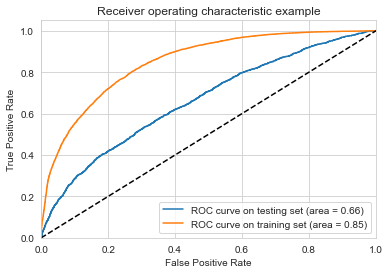

In [48]:
# Use defined function plot roc curve and print roc auc score
plot_roc_curve(model, train, test)


In [50]:
# Evaluate the feature importances and plot the charts for most important 20 features
importance = model.bestModel.featureImportances
features_list = inputcols
feature_importance = pd.DataFrame(
    data={"features_list": features_list, "importance": importance}
)
feature_importance = feature_importance.sort_values(by="importance", ascending=False)[:20]
sns.catplot(
    x="importance",
    y="features_list",
    data=feature_importance,
    kind="bar",
    height=5,
    aspect=2.7,
)
plt.ylabel("Feature", fontsize=15)
plt.xlabel("Feature Importance", fontsize=15)


TypeError: '<' not supported between instances of 'SparseVector' and 'SparseVector'

### 5.3 Gradient-Boosted Trees(GBTs) Classifier

In [ ]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
gbt = GBTClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction"
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [8, 10])
    .addGrid(gbt.minInstancesPerNode, [5, 20, 50])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters that performed best.
model.transform(test).select("features", "label", "prediction").show(10)


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(56,[0,1,2,3,6,7,...|    1|       1.0|
|(56,[0,1,2,4,6,7,...|    1|       0.0|
|(56,[0,1,2,5,7,8,...|    1|       1.0|
|(56,[0,1,2,3,4,6,...|    1|       0.0|
|(56,[0,1,2,3,4,5,...|    1|       1.0|
|(56,[0,1,2,3,4,6,...|    1|       0.0|
|(56,[0,1,2,3,5,6,...|    1|       1.0|
|(56,[0,1,2,6,7,11...|    1|       1.0|
|(56,[0,1,2,3,4,6,...|    1|       0.0|
|(56,[0,2,7,21,22,...|    1|       1.0|
+--------------------+-----+----------+
only showing top 10 rows



In [ ]:
# From the best model take chosen hyper-parameters 
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])


cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
labelCol : label
lossType : logistic
maxBins : 32
maxDepth : 8
maxIter : 20
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 50
predictionCol : prediction
seed : 7436818841250171960
stepSize : 0.1
subsamplingRate : 1.0


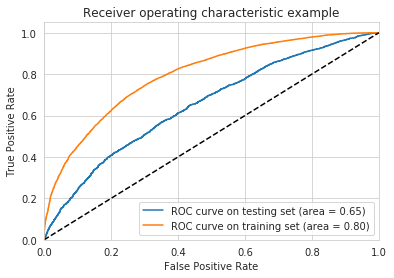

In [ ]:
# Use defined function plot roc curve and print roc auc score
plot_roc_curve(model, train, test)


### 5.4 Use XGBoost Regressor Algorithm Build Revenue Loss Prediction Model

In [ ]:
# Transofrm scaledData into pandas Dataframe so we can use XGBoost and Keras
dataset = scaledData.toPandas()

# Create revenue loss column as label
dataset["revenue_loss"] = dataset.label * dataset.MonthlyRevenue

# Create the list of features
feature_list = [
    column
    for column in dataset.columns
    if column
    not in ["CustomerID", "label", "features", "revenue_loss", "scaledFeatures"]
]

# Create X, y, and split into train/test sets
X = dataset.loc[:, feature_list]
y = dataset.revenue_loss
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Use GridSearch method to figure the best hyper-parameters
# Parameters to search over with cross-validation
grid_params = [
    {
        "max_depth": [4, 5],
        "learning_rate": [0.1, 1],
        "n_estimators": [10, 100],
        "reg_lambda": [100, 10],
        "objective": ["reg:linear"],
    }
]

xgbr = GridSearchCV(xgb.XGBRegressor(), grid_params, cv=5, scoring="r2")
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

print("Mean Absolute Error: %r\n" % metrics.mean_absolute_error(y_test, y_pred))
print("Best parameter values: %r\n" % xgbr.best_params_)


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

Mean Absolute Error: 22.42623

Best parameter values: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'reg:linear', 'reg_lambda': 100}



/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Highest Risk Group(5.00% of total clients) can capture 16.73% of total revenue_loss


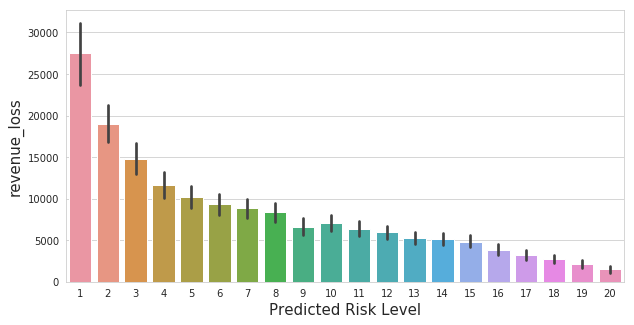

In [ ]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)


### 5.5 Use Keras deploy Nural networks to predict revenue loss

In [ ]:
a = 0.0005
drop = 0.2
n = X_train.shape[1]

model = Sequential(
    [
        Dense(
            int(n * 1.2),
            input_dim=n,
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
            activation="relu",
        ),
        Dropout(drop),
        Dense(
            int(n), kernel_regularizer=regularizers.l1_l2(l1=a, l2=a), activation="relu"
        ),
        Dropout(drop),
        Dense(
            int(n * 0.8),
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
        ),
        Dense(1),
    ]
)


In [ ]:
# Prints a summary representation of model
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 67)                3819      
_________________________________________________________________
dropout_3 (Dropout)          (None, 67)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 56)                3808      
_________________________________________________________________
dropout_4 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                2508      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 45        
Total params: 10,180
Trainable params: 10,180
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Configures the model for training and fit the training set
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae", "accuracy"])
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=5, verbose=1, shuffle=True
)


Train on 31840 samples, validate on 7961 samples
Epoch 1/5
31840/31840 [==============================] - 3s 89us/step - loss: 1306.6934 - mean_absolute_error: 23.9662 - acc: 0.0069 - val_loss: 1242.0774 - val_mean_absolute_error: 22.9514 - val_acc: 3.7684e-04
Epoch 2/5
31840/31840 [==============================] - 2s 58us/step - loss: 1190.4134 - mean_absolute_error: 23.1084 - acc: 9.4221e-04 - val_loss: 1216.9033 - val_mean_absolute_error: 22.8458 - val_acc: 6.2806e-04
Epoch 3/5
31840/31840 [==============================] - 2s 59us/step - loss: 1152.8852 - mean_absolute_error: 23.0983 - acc: 6.5955e-04 - val_loss: 1201.6919 - val_mean_absolute_error: 22.0765 - val_acc: 0.0000e+00
Epoch 4/5
31840/31840 [==============================] - 2s 64us/step - loss: 1138.3164 - mean_absolute_error: 22.9659 - acc: 3.7688e-04 - val_loss: 1212.3727 - val_mean_absolute_error: 21.2061 - val_acc: 1.2561e-04
Epoch 5/5
31840/31840 [==============================] - 2s 65us/step - loss: 1112.4188 - m

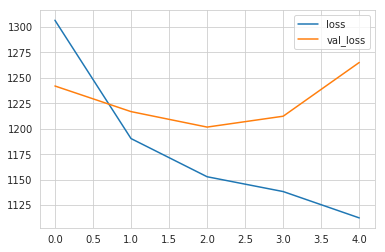

In [ ]:
# plot loss metrics
ax1 = plt.plot(history.history["loss"])
ax2 = plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])


In [ ]:
# Use model redict test set
y_pred = model.predict(X_test)
y_test = np.array(y_test)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Highest Risk Group(5.00% of total clients) can capture 16.85% of total revenue_loss


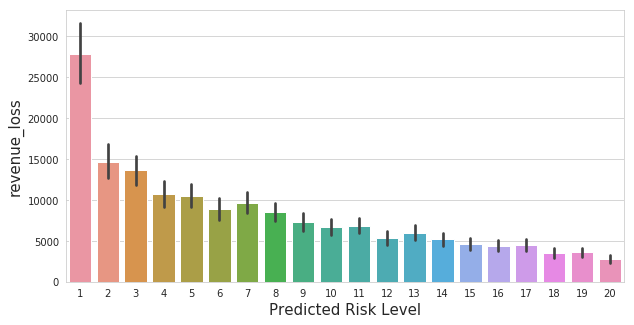

In [ ]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)


## 6. Customer Segmentation  <a name="Segmentation"></a>

In this module, we'll use KMeans to build a Customer Segmentation model, and then we can compare the different distributions of each cluster.

Customer segmentation is the practice of dividing customers into groups of individuals that are similar in specific ways relevant to marketing, such as age, months in service, services usage and services spending.

Based on the customer segmentation, the telecommunications company can customize their marketing efforts for different cluster, and gain a deeper understanding of their customers' preferences in order to more accurately tailor marketing materials.


In [ ]:
# Trains a k-means model
kmeans = KMeans(featuresCol="scaledFeatures", k=4, initSteps=2, tol=0.0001, maxIter=20)
model = kmeans.fit(scaledData)

In [ ]:
# Make predictions
predictions = model.transform(scaledData)


In [ ]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.007144003364105086


In [ ]:
# Create a Pandas DataFrame for data visualization
cluster = predictions.toPandas()


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


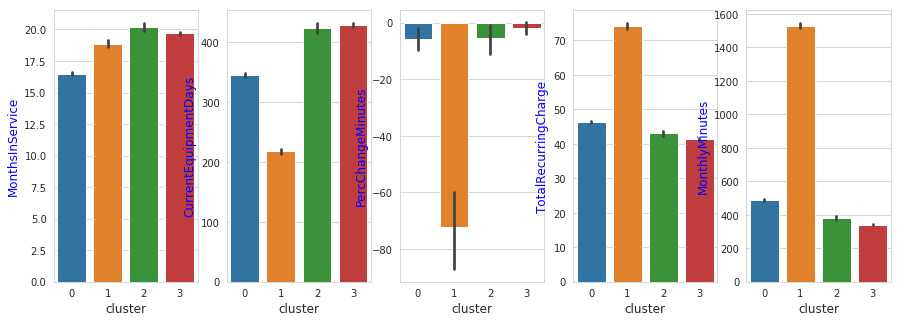

In [ ]:
# Compare the different distributions of each cluster
temp_list = list(feature_importance.iloc[:5, 0])
temp_list.append("prediction")
temp = cluster.loc[:, temp_list]

fig, axs = plt.subplots(figsize=(15, 5), ncols=len(temp_list) - 1)

for i in range(len(temp_list) - 1):
    ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i])
    ax.set_xlabel("cluster", fontsize=12)
    ax.set_ylabel(temp_list[i], fontsize=12, color="blue")


## 7. Results and Discussion <a name="results"></a>

Due to the lack of missing some important feature, we can see the overall classification performance is not perfect enough. However, we can still catch the highest risk group so the stakeholders can focus on those groups based on the predicted risk level, so they can put less retention cost but save more revenue loss.

From the result of the segmentation model, we can see that all customers have been separated into different clusters perfectly. Customer segmentation begins with gathering and analyzing data and ends with acting on the information gathered in a way that is appropriate and effective. So the next step in real business is based on these clusters and distributions, following with analytical technique such as Uplift Modeling to models the difference in behavior between target and control groups, so the business owner can customize their up-sale and cross-sale strategy. 